In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import box, LineString
import os
from matplotlib import pyplot
from pyproj import Transformer

In [24]:
basedir = '/gpfs/space/home/etais/hpc_nikolaykozlovskiy/transformers_project/Traffic4cast/data_traffic'
road_graph_folder = 'road_graph'
spatial_data_folder = 'spatial_data'
preprocess_stage = 'land_cover'
buffer_m = 50
city = 'london'
crs_reprj = {'london': 27700}
city_epsg = crs_reprj[city]

In [3]:
road_graph_nodes = pd.read_parquet(f'{basedir}/{road_graph_folder}/{city}/road_graph_nodes.parquet')
road_graph_edges = pd.read_parquet(f'{basedir}/{road_graph_folder}/{city}/road_graph_edges.parquet')

In [6]:
road_graph_edges = road_graph_edges.merge(road_graph_nodes[['node_id', 'x', 'y']], 
                                          left_on = 'u', 
                                          right_on = 'node_id'
                                         )
road_graph_edges = road_graph_edges.merge(road_graph_nodes[['node_id', 'x', 'y']], 
                                          left_on = 'v', 
                                          right_on = 'node_id', 
                                          suffixes = ('_start', '_end')
                                         )

In [7]:
road_graph_edges['geometry'] = road_graph_edges.apply(lambda row:
    LineString([[row['x_start'], row['y_start']],[row['x_end'], row['y_end']]]), axis=1
)

In [8]:
gdf_road_graph_edges = gpd.GeoDataFrame(
    road_graph_edges,
    crs = 4326,
    geometry = 'geometry'
)

In [9]:
gdf_road_graph_edges = gdf_road_graph_edges.to_crs(city_epsg)
gdf_road_graph_edges['geometry'] = gdf_road_graph_edges['geometry'].buffer(buffer_m)

In [20]:
transformer = Transformer.from_crs(city_epsg, 4326, always_xy=True)
city_bounding_box = box(*transformer.transform_bounds(*gdf_road_graph_edges.total_bounds))

In [15]:
land_cover_city_dir = f'{basedir}/{spatial_data_folder}/{preprocess_stage}/{city}'
tif_files = os.listdir(f'{land_cover_city_dir}/raw')
datasets = []
if len(tif_files) != 1:
    for tif_file in tif_files: 
        data = rasterio.open(os.path.join(f'{land_cover_city_dir}/raw', tif_file), 'r')
        datasets.append(data)
    land_cover_np_arr, out_transform= merge(datasets)
    out_meta = data.meta.copy()
    out_meta.update({
        'driver':'GTiff', 
        'height':land_cover_np_arr.shape[1],
        'width':land_cover_np_arr.shape[2], 
        'transform':out_transform
    })
    merged_output_path = f'{land_cover_city_dir}/processed/merged.tif'
    with rasterio.open(merged_output_path, 'w', **out_meta) as dest:
        dest.write(land_cover_np_arr)

    land_cover_tif = rasterio.open(merged_output_path, 'r')
    
else: 
    land_cover_tif = rasterio.open(os.path.join(land_cover_city_dir, tif_files[0]), 'r')

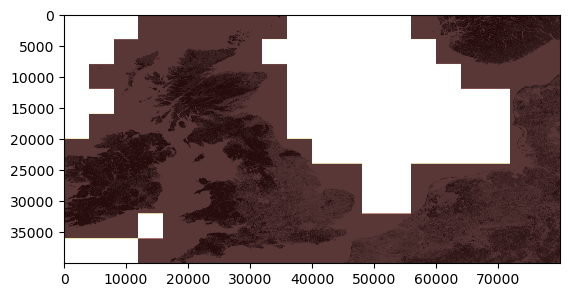

In [10]:
pyplot.imshow(land_cover_tif.read(1), cmap='pink')
pyplot.show()

In [19]:
land_cover_tif.crs

CRS.from_epsg(4326)

In [22]:
land_cover_masked, out_transform = mask(dataset=land_cover_tif,
                                        shapes = [city_bounding_box], 
                                        crop = True
                                        )

out_meta = land_cover_tif.meta.copy()
out_meta.update({
    'driver':'GTiff', 
    'height':land_cover_masked.shape[1],
    'width':land_cover_masked.shape[2], 
    'transform':out_transform
})

masked_output_path = f'{land_cover_city_dir}/processed/masked.tif'
with rasterio.open(masked_output_path, 'w', **out_meta) as dest:
    dest.write(land_cover_masked)

land_cover_masked_tif = rasterio.open(masked_output_path, 'r')

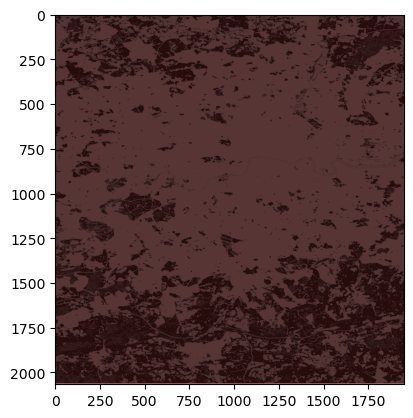

In [23]:
pyplot.imshow(land_cover_masked_tif.read(1), cmap='pink')
pyplot.show()

In [13]:
src_file = masked_output_path
dst_file = f'{land_cover_city_dir}/processed/reprojected.tif'
dst_crs = rasterio.crs.CRS.from_epsg(epsg)

with rasterio.open(src_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(dst_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
land_cover_reprojected_tif = rasterio.open(dst_file, 'r')

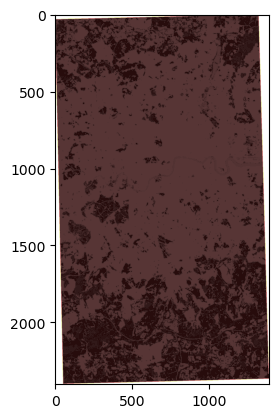

In [14]:
pyplot.imshow(land_cover_reprojected_tif.read(1), cmap='pink')
pyplot.show()

In [16]:
land_cover_edges = np.zeros((road_graph_edges.shape[0],
                             19
                             ))

In [41]:
# 3 minutes
for i in range(road_graph_edges.shape[0]):
    edge = gdf_road_graph_edges.iloc[i]['geometry']
    out_arr, out_transform = mask(dataset=land_cover_reprojected_tif, 
                                  shapes=[edge],
                                  crop=True
                                 )
    values, counts = np.unique(out_arr-1, return_counts=True)
    land_cover_edges[i, values[:-1]] = counts[:-1]

In [42]:
land_cover_edges_copy = land_cover_masked.copy()

In [43]:
land_cover_edges = np.delete(land_cover_edges, [5,6,12,13,14], axis = 1)

In [46]:
percentages = np.round(land_cover_edges/land_cover_edges.sum(axis=1, keepdims=True) * 100,0)

In [51]:
percentages = percentages.astype(np.uint8)

In [55]:
land_cover_columns = [f'lc_{i}' for i in range(percentages.shape[1])]

In [56]:
gdf_road_graph_edges[land_cover_columns] = percentages

In [57]:
gdf_road_graph_edges

,u,v,parsed_maxspeed,speed_kph,importance,highway,oneway,lanes,tunnel,length_meters,...,lc_4,lc_5,lc_6,lc_7,lc_8,lc_9,lc_10,lc_11,lc_12,lc_13
0,78112,25508583,32.2,32.2,0,unclassified,False,,,19.402386,...,0,0,0,0,0,0,0,0,100,0
1,103928,25508583,32.2,32.2,0,unclassified,False,,,77.320838,...,0,0,0,0,0,0,0,0,100,0
2,6185893543326383803,25508583,32.2,32.2,0,residential,True,,,18.129357,...,0,0,0,0,0,0,0,0,100,0
3,78112,25508584,32.2,32.2,0,unclassified,False,,,63.881347,...,0,0,0,0,0,0,0,0,100,0
4,4595403137,25508584,32.2,32.2,0,unclassified,False,,,13.164101,...,0,0,0,0,0,0,0,0,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132409,2558111688715178165,1340686223633347396,112.7,112.7,5,motorway,True,4,,644.905213,...,2,0,0,0,0,0,0,14,53,0
132410,7889378430193093482,8950740246685556598,112.7,112.7,5,motorway,True,4,,541.484864,...,0,0,0,0,0,0,0,12,76,0
132411,2285140568209560452,64940756507041461,112.7,112.7,5,motorway,True,4,,496.122252,...,0,0,0,0,0,0,0,25,51,0
132412,7056784350608841276,1799382306681622021,112.7,112.7,5,motorway,True,4,,300.054163,...,0,0,0,0,0,0,0,0,58,0
